# **Autoencoder no lineal implementado con Keras/Tensorflow**

**Importación de librerías**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

**Definición de funciones auxiliares**

In [ ]:
def plot_image(image, cmap="binary"):
  plt.imshow(image, cmap=cmap)
  plt.axis("off")

def plot_images(X, cmap="binary", cols=10, widthsize=12):
  rows = int(np.ceil(len(X)/cols))
  plt.figure(figsize=(widthsize, widthsize/cols*rows))
  cont = 1
  for image in X:
    plt.subplot(rows,cols,cont)
    plot_image(image)
    cont = cont + 1

def plot_original_vs_reconstruida(X_original, X_reconstruida):
  for imagen_orig, imagen_rec in zip(X_original, X_reconstruida):
    plt.figure(figsize=(2,1))
    plt.subplot(1,2,1)
    plot_image(imagen_orig)
    plt.title("Original", fontsize=10)
    plt.subplot(1,2,2)
    plot_image(imagen_rec)
    plt.title("Reconstruida", fontsize=10)

def show_ests(y, title=None):
  clases, counts = np.unique(y, return_counts=True)
  plt.figure(figsize=(7,1.5))
  plt.bar(clases, counts)
  if title:
      plt.title(title, fontsize=18)
  plt.xticks(clases)

def show_error(error):
  img = np.zeros((error.shape[0],error.shape[1],3))
  img[:,:,1] = np.clip(error, 0, 1)
  img[:,:,2] = np.clip(error, 0, 1)

  img[:,:,0] = -np.clip(error, -1, 0)
  img[:,:,1] = img[:,:,1] - np.clip(error, -1, 0)

  plt.imshow(1-img**2, vmin=0, vmax=1)
  plt.axis("off")

def show_errors(errors, cols=10, widthsize=12):
  rows = int(np.ceil(len(errors)/cols))
  plt.figure(figsize=(widthsize, widthsize/cols*rows))
  cont = 1
  for error in errors:
    plt.subplot(rows,cols,cont)
    show_error(error)
    cont = cont + 1

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**Carga de datos**

In [ ]:
(X_trval, y_trval), (X_test, y_test) = mnist.load_data()
#(X_trval, y_trval), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_valid = X_trval[:-5000], X_trval[-5000:]
y_train, y_valid = y_trval[:-5000], y_trval[-5000:]

11490434/11490434 [==============================] - 0s 0us/step


**Estadísticas de las clases**

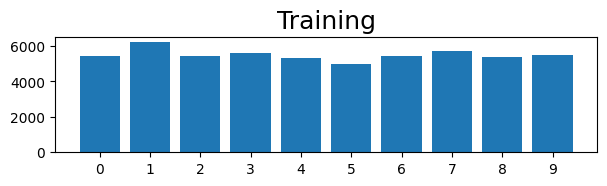

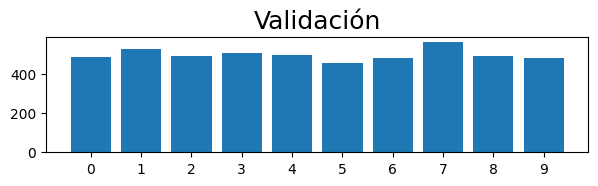

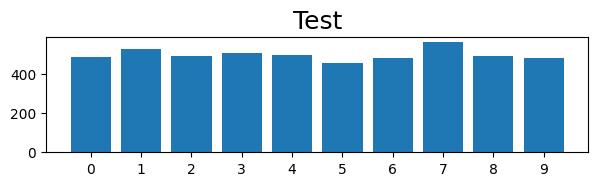

In [ ]:
show_ests(y_train, title="Training")
show_ests(y_valid, title="Validación")
show_ests(y_valid, title="Test")

In [ ]:
print()
print(np.unique(y_valid))
print(np.unique(y_train))


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


**Chequeao de dimensionaes de datos**

In [ ]:
X_train.shape

(55000, 28, 28)

**Normalización**

In [ ]:
X_train.min(), X_train.max()

(0, 255)

In [ ]:
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape)
print(X_test.shape)

(55000, 28, 28)
(10000, 28, 28)


In [ ]:
X_train.min(), X_train.max()

(0.0, 1.0)

**Se muestran 100 imágenes al azar**

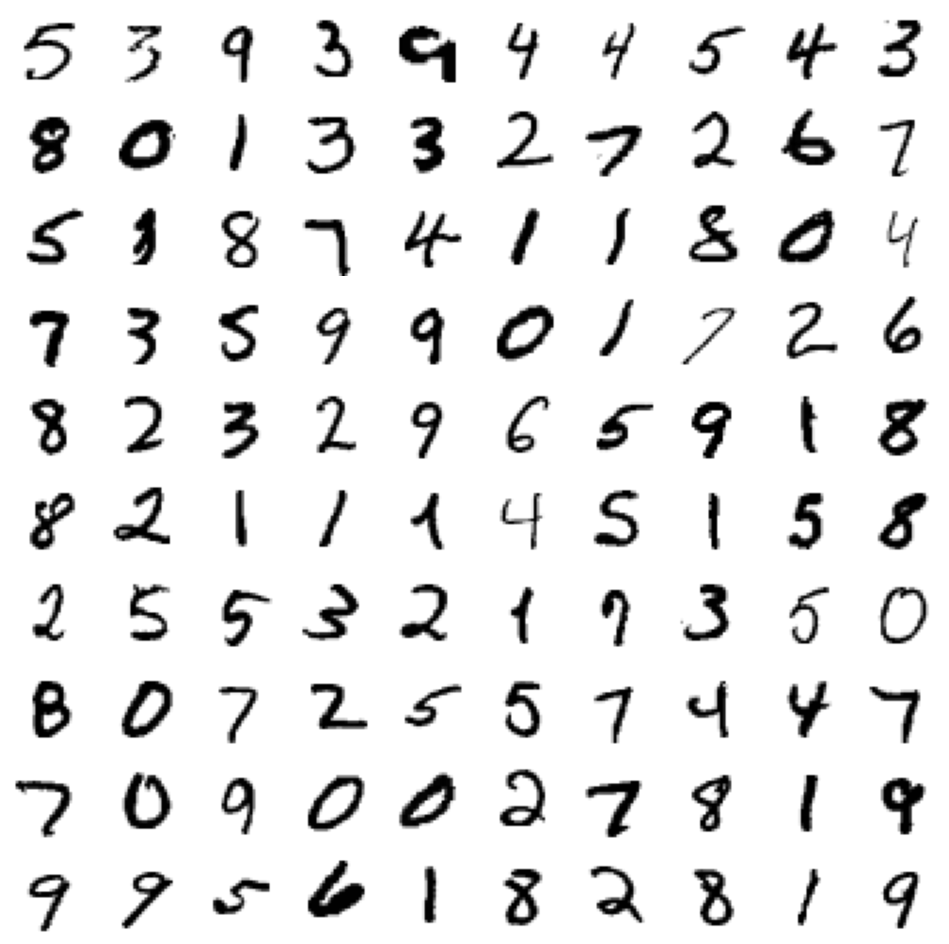

In [ ]:
inds = np.random.randint(0, len(X_train), 100)
plot_images(X_train[inds])

## **Definición del Autoencoder basado en PCA**

In [ ]:
import keras
from matplotlib.ticker import MaxNLocator

class mi_ae():
  def __init__(self, n_components):
    self.encoder = keras.models.Sequential(
        [
            keras.Input((28,28)),
            keras.layers.Flatten(),
            keras.layers.Dense(50, activation="relu"),
            keras.layers.Dense(n_components, activation="relu")
        ])
    self.decoder = keras.models.Sequential(
        [
            keras.layers.Dense(50, activation="relu"),
            keras.layers.Dense(28*28, activation="sigmoid"),
            keras.layers.Reshape((28,28))
        ])
    self.ae = keras.models.Sequential([self.encoder, self.decoder])
    self.ae.compile(optimizer='adam', loss="mse")

  def fit(self, X_tr, X_val, epocas=100):
    lista_callbacks = [
      keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
      ),
      keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True,
      )
    ]
    historia = self.ae.fit(X_tr, X_tr, batch_size=128, epochs=epocas, callbacks=lista_callbacks,
                           validation_data=(X_val, X_val))

    f = plt.figure(figsize=(4,4))
    h = historia.history
    aux = range(len(h["loss"]))
    mejor_epoca = np.argmin(h["val_loss"])
    plt.plot(aux, h["loss"], "k", label="entrenamiento")
    plt.plot(aux, h["val_loss"], "--k", label="validación")
    plt.plot(mejor_epoca, h["val_loss"][mejor_epoca], 'ok')
    plt.title('Loss', fontsize=18)
    plt.xlabel('Época', fontsize=18)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.legend()
    f.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    self.ae = keras.models.load_model("best_model.keras")

  def encode(self, X):
    return self.encoder.predict(X, verbose=0)

  def decode(self, X):
    return self.decoder.predict(X, verbose=0)

In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
X_valid.shape

(5000, 28, 28)

Epoch 1/50
430/430 [==============================] - 11s 19ms/step - loss: 0.0613 - val_loss: 0.0422
Epoch 2/50
430/430 [==============================] - 5s 13ms/step - loss: 0.0366 - val_loss: 0.0330
Epoch 3/50
430/430 [==============================] - 4s 10ms/step - loss: 0.0321 - val_loss: 0.0308
Epoch 4/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0302 - val_loss: 0.0291
Epoch 5/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0284 - val_loss: 0.0272
Epoch 6/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0270 - val_loss: 0.0263
Epoch 7/50
430/430 [==============================] - 5s 11ms/step - loss: 0.0262 - val_loss: 0.0257
Epoch 8/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 9/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 10/50
430/430 [==============================] - 3s 8ms/step - loss: 0.0249 - val_loss: 0

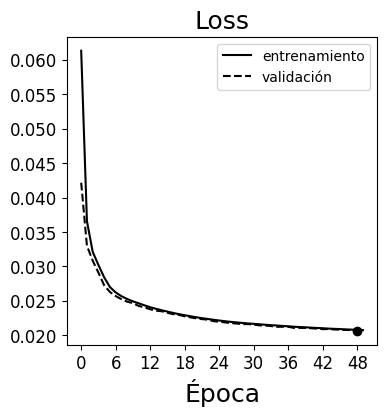

In [ ]:
n_components = 10
ae = mi_ae(n_components)
ae.fit(X_train, X_valid, epocas=50)

In [ ]:
# Comprimo las imágenes con el encoder:
X_test_enc = ae.encode(X_test)

In [ ]:
X_test_enc.shape

(10000, 10)

In [ ]:
X_test_enc[:5]

array([[ 5.722462 , 10.4798975,  9.065647 , 14.732275 ,  4.0950966,
        22.79327  , 15.296572 , 11.040691 , 11.7981415,  4.515903 ],
       [25.665628 , 13.042722 , 21.102633 , 16.05376  , 23.364346 ,
        13.134278 ,  7.4496455, 15.092684 , 11.00964  ,  7.949445 ],
       [12.01104  ,  4.085185 , 16.938221 ,  0.7900951,  8.110179 ,
        23.16983  ,  3.8909526,  2.4607449,  2.5248566,  5.3603997],
       [21.767025 , 19.984776 , 13.521138 , 29.72701  , 26.783802 ,
        22.611153 , 19.201803 , 12.920187 , 22.484715 , 12.026486 ],
       [12.484847 ,  7.385333 , 10.5378685, 14.782369 ,  7.820844 ,
        11.011963 , 18.597038 , 11.141322 , 11.927059 , 11.114657 ]],
      dtype=float32)

**Visualización del dataset en las 2 primeras dimensiones del espacio latente**

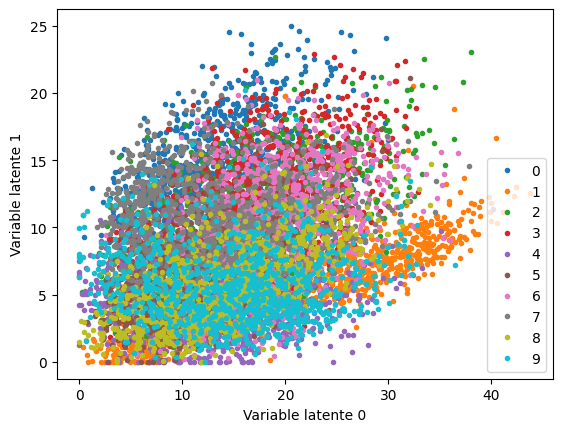

In [ ]:
for digito in range(10):
  aux = (y_test == digito) # filtro (selecciono solo imágenes de clase=digito)
  plt.plot(X_test_enc[aux, 0], X_test_enc[aux, 1], ".", label=digito)
  plt.xlabel("Variable latente 0")
  plt.ylabel("Variable latente 1")
plt.legend();

**Visualización del dataset en las 3 primeras dimensiones del espacio latente**

In [ ]:
configure_plotly_browser_state()

data = []
for digito in range(10):
  data.append(go.Scatter3d(x=X_test_enc[y_test==digito,0],
                           y=X_test_enc[y_test==digito,1],
                           z=X_test_enc[y_test==digito,2],
                           mode='markers', name=str(digito),
                           marker=dict(size=3, symbol="circle",
                                       opacity=0.9)))

layout = go.Layout(title='Espacio latente',
                   scene={"xaxis":{"title":"Variable latente 0"},
                          "yaxis":{"title":"Variable latente 1"},
                          "zaxis":{"title":"Variable latente 2"}})

py.iplot(go.Figure(data=data, layout=layout))

**Reconstrucción de las imágenes tras pasar por el autoencoder**

In [ ]:
# Descomprimo las imágenes con el decoder:
X_test_rec = ae.decode(X_test_enc)
X_test_rec.shape

(10000, 28, 28)

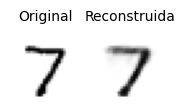

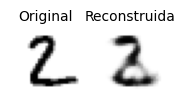

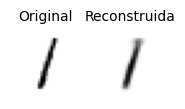

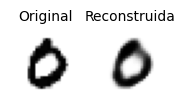

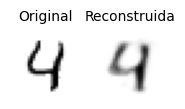

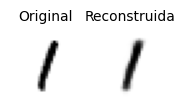

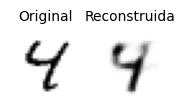

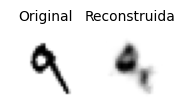

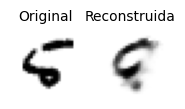

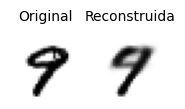

In [ ]:
plot_original_vs_reconstruida(X_test[:10], X_test_rec[:10])

## ¿Cuáles son las 10 imágenes más anómalas en test?

In [ ]:
errores_pixeles_signo = X_test - X_test_rec
errores_pixeles_signo.shape

(10000, 28, 28)

In [ ]:
errores_pixeles = errores_pixeles_signo**2
errores_pixeles.shape

(10000, 28, 28)

In [ ]:
errores = errores_pixeles.mean(axis=1).mean(axis=1) # calculo el ECM de reconstrucción por cada imagen
errores.shape

(10000,)

In [ ]:
inds = np.argsort(errores)[::-1] # Índices de imágenes ordenadas por error (de mayor a menor)
inds

array([3817, 4601, 8553, ..., 3815, 2688, 7686])

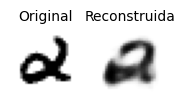

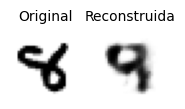

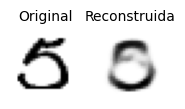

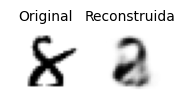

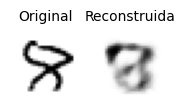

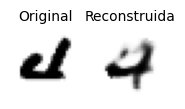

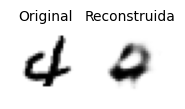

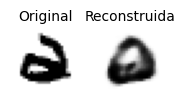

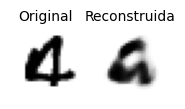

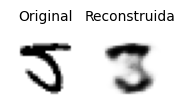

In [ ]:
plot_original_vs_reconstruida(X_test[inds[:10]], X_test_rec[inds[:10]])

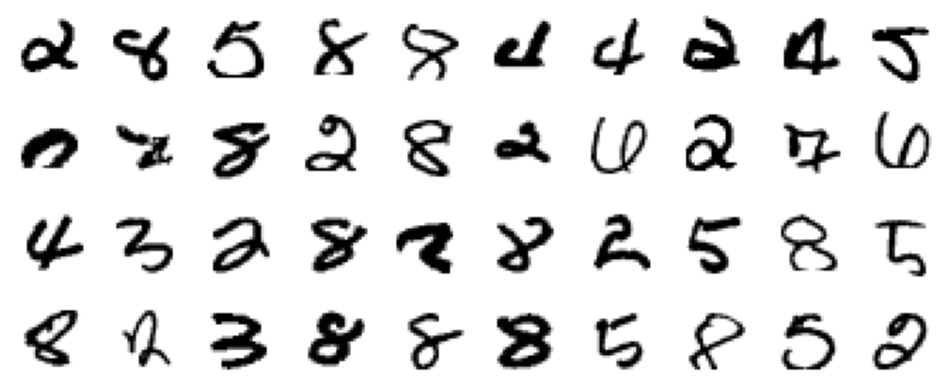

In [ ]:
plot_images(X_test[inds[:40]])

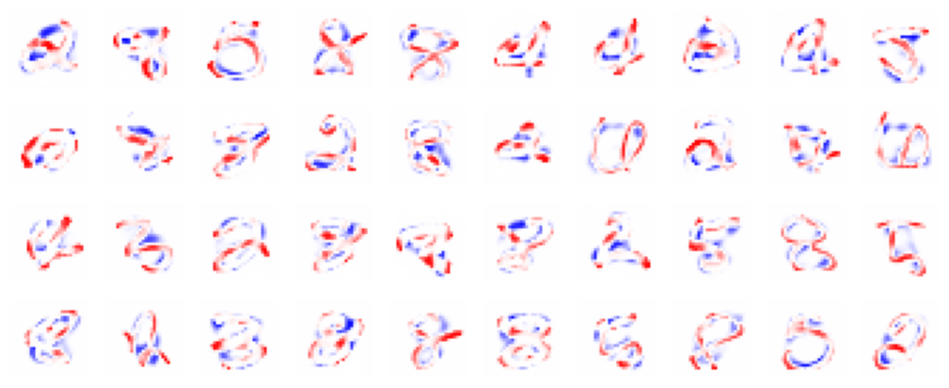

In [ ]:
show_errors(errores_pixeles_signo[inds[:40]])

## ¿Cuáles son las 10 imágenes menos anómalas en test?

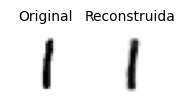

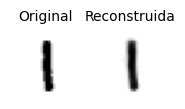

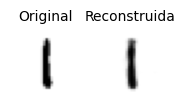

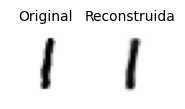

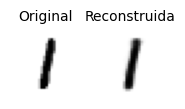

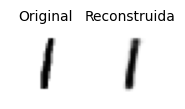

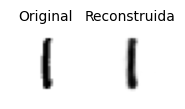

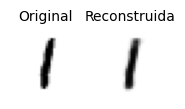

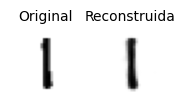

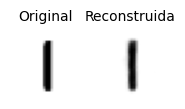

In [ ]:
plot_original_vs_reconstruida(X_test[inds[-10:]], X_test_rec[inds[-10:]])

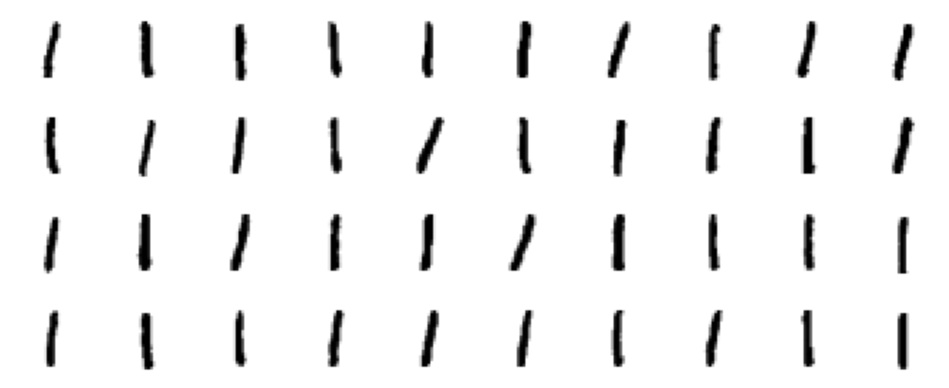

In [ ]:
plot_images(X_test[inds[-40:]])

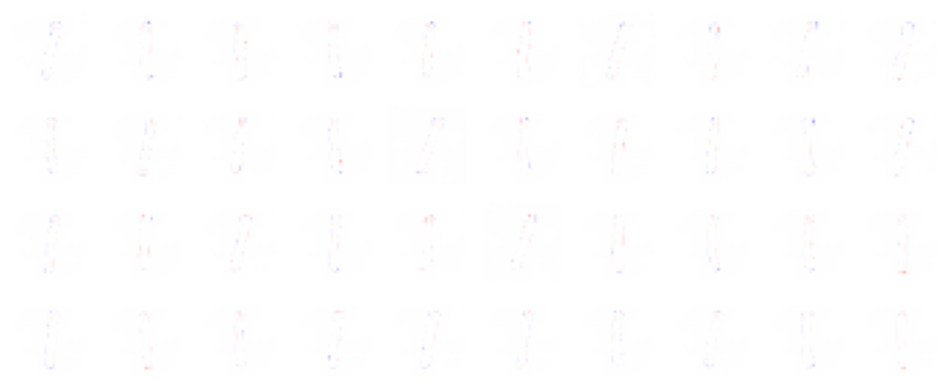

In [ ]:
show_errors(errores_pixeles_signo[inds[-40:]])

## Autocompletado de información

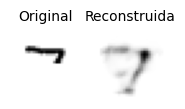

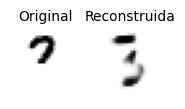

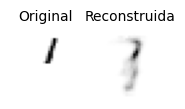

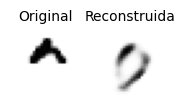

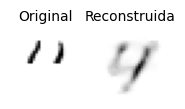

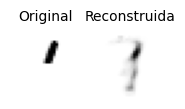

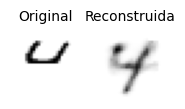

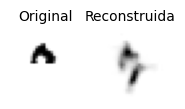

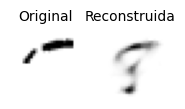

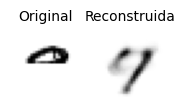

In [ ]:
X_incompleto = X_test[:10].copy()
X_incompleto[:,14:] = 0

plot_original_vs_reconstruida(X_incompleto, ae.decoder(ae.encoder(X_incompleto)))

## Generación de imágenes nuevas

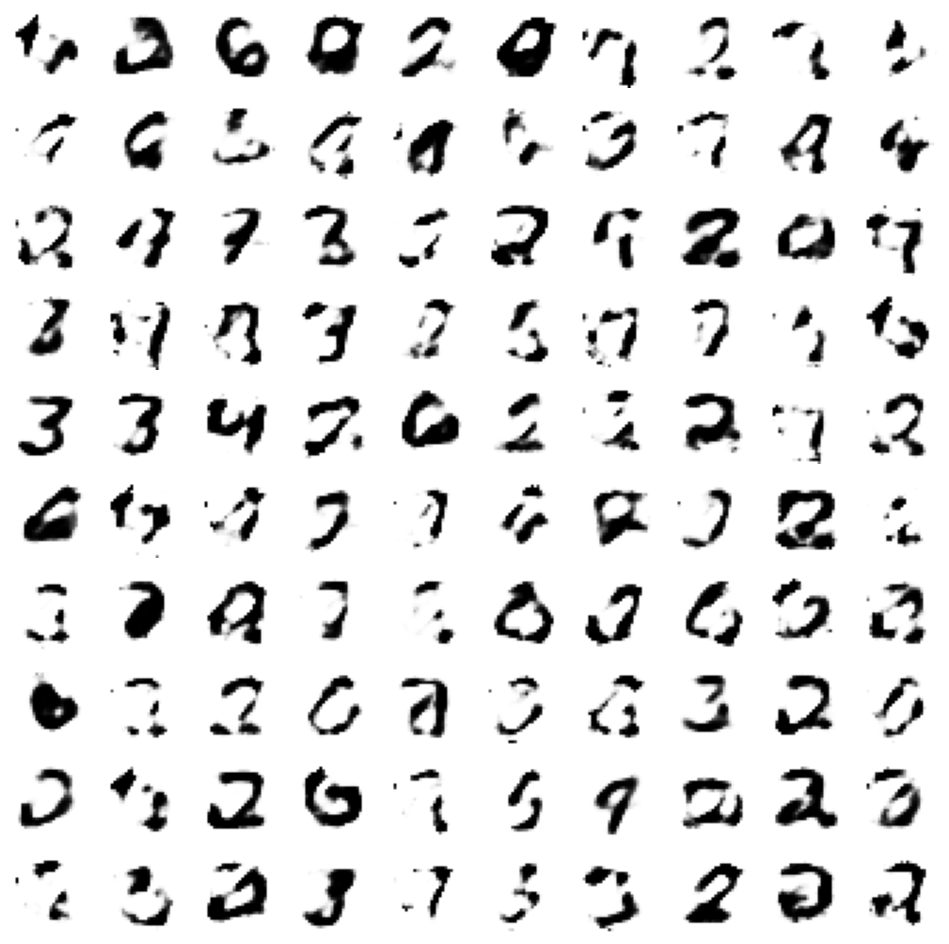

In [ ]:
n_digitos_nuevos = 100
input_aleatorio_decoder = X_test_enc.max()*np.random.rand(n_digitos_nuevos, n_components) # np.random.rand va entre 0 y 1
nuevos = ae.decode(input_aleatorio_decoder)
plot_images(nuevos)